# Credit Card Fraud Detection – End-to-End Analysis

This notebook builds and evaluates machine learning models to detect fraudulent credit card transactions.

## Objectives

1. Explore the dataset and understand the feature relationships.
2. Handle strong class imbalance in the target (`fraud`).
3. Build and compare several models using **proper validation**:
   - No data leakage
   - Stratified train/test split
   - Cross-validation with ROC-AUC & PR-AUC
4. Evaluate the best model on a held-out test set.
5. Interpret the model with feature importance.

---

**Dataset**: `card_transdata.csv`  
Each row represents a credit card transaction with a binary label: `fraud` (0 = legit, 1 = fraud).

In [2]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML tools
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Misc
import warnings
warnings.filterwarnings("ignore")

# Plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)


In [3]:
# Load the dataset
df = pd.read_csv('card_transdata.csv')

# Basic Data Inspection
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:")
print(df.head())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nFraud Distribution (0=Legit, 1=Fraud):")
print(df['fraud'].value_counts(normalize=True))

Dataset Shape: (1000000, 8)

First 5 Rows:
   distance_from_home  distance_from_last_transaction  \
0           57.877857                        0.311140   
1           10.829943                        0.175592   
2            5.091079                        0.805153   
3            2.247564                        5.600044   
4           44.190936                        0.566486   

   ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                        1.945940              1.0        1.0   
1                        1.294219              1.0        0.0   
2                        0.427715              1.0        0.0   
3                        0.362663              1.0        1.0   
4                        2.222767              1.0        1.0   

   used_pin_number  online_order  fraud  
0              0.0           0.0    0.0  
1              0.0           0.0    0.0  
2              0.0           1.0    0.0  
3              0.0           1.0    0.0  
4            

Class counts:
fraud
0.0    912597
1.0     87403
Name: count, dtype: int64

Class ratios:
fraud
0.0    0.912597
1.0    0.087403
Name: count, dtype: float64


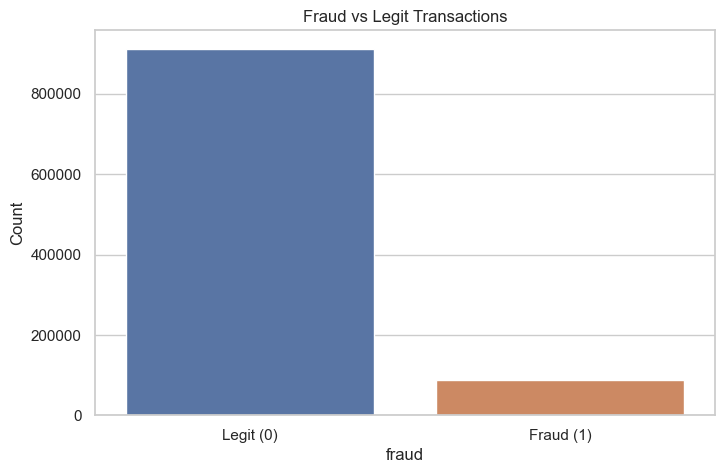

In [4]:
# Fraud distribution
fraud_counts = df["fraud"].value_counts().sort_index()
fraud_ratio = fraud_counts / len(df)

print("Class counts:")
print(fraud_counts)
print("\nClass ratios:")
print(fraud_ratio)

# Bar plot
plt.figure()
sns.barplot(x=fraud_counts.index.astype(int), y=fraud_counts.values)
plt.xticks([0, 1], ["Legit (0)", "Fraud (1)"])
plt.ylabel("Count")
plt.title("Fraud vs Legit Transactions")
plt.show()


We can see that the dataset is **heavily imbalanced**, with fraud cases representing only a small fraction of all transactions.  
This means **accuracy alone will be misleading**, so we will use metrics such as:

- ROC-AUC
- Precision-Recall AUC (Average Precision)
- Precision, Recall, F1-score


## Exploratory Data Analysis (EDA)

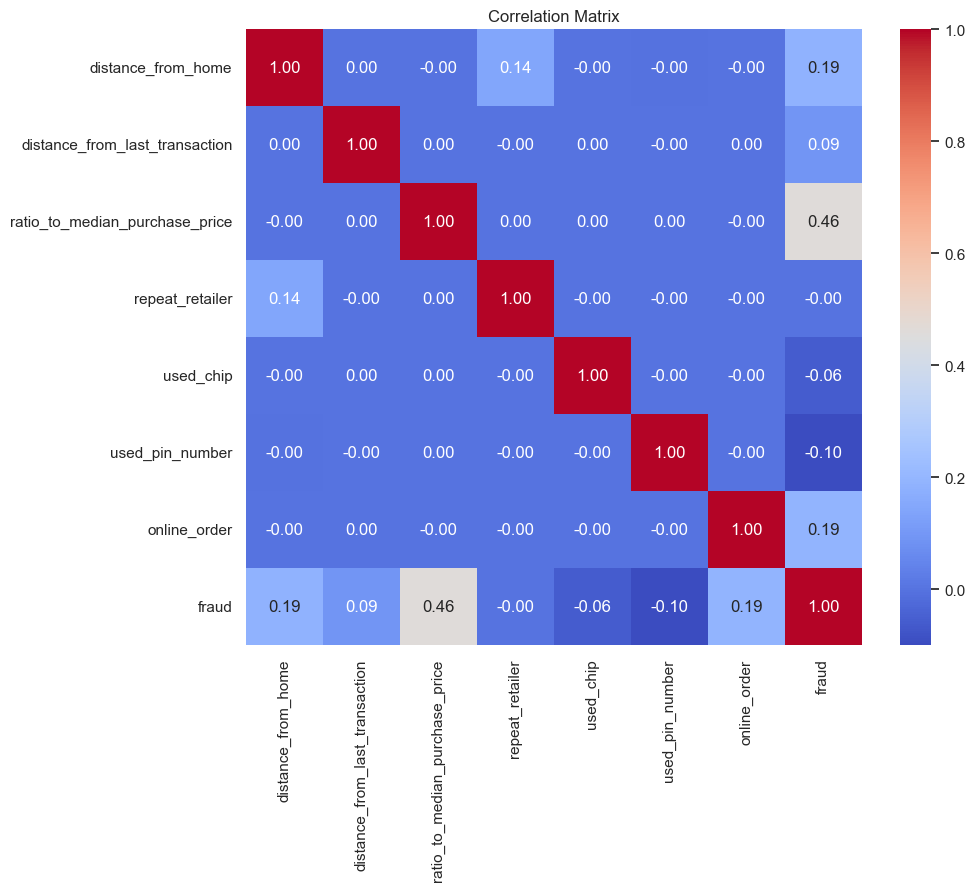

In [5]:
plt.figure(figsize=(10, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()


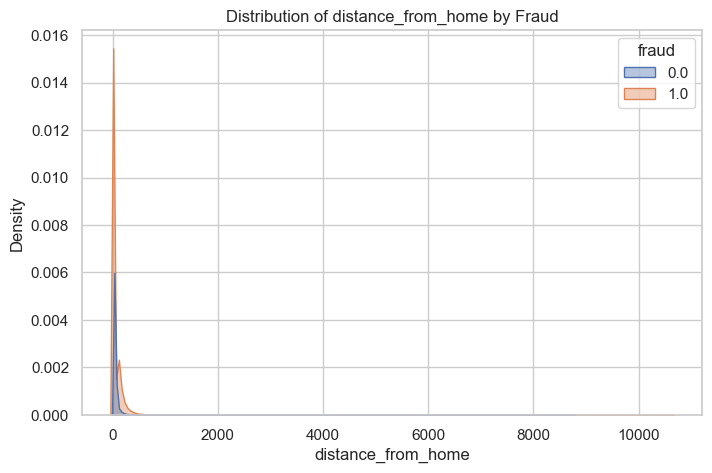

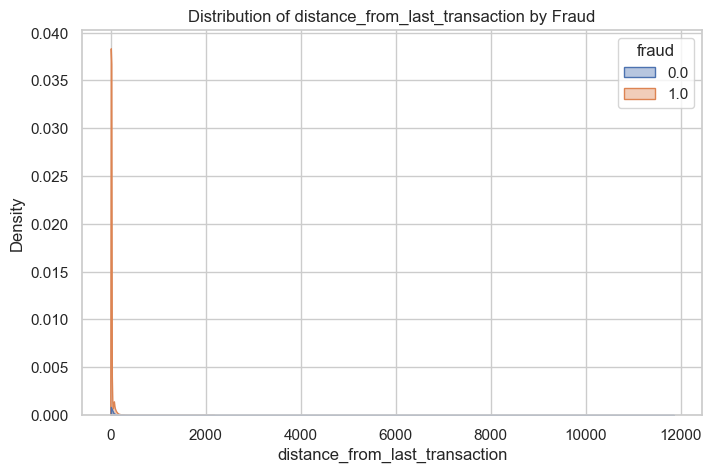

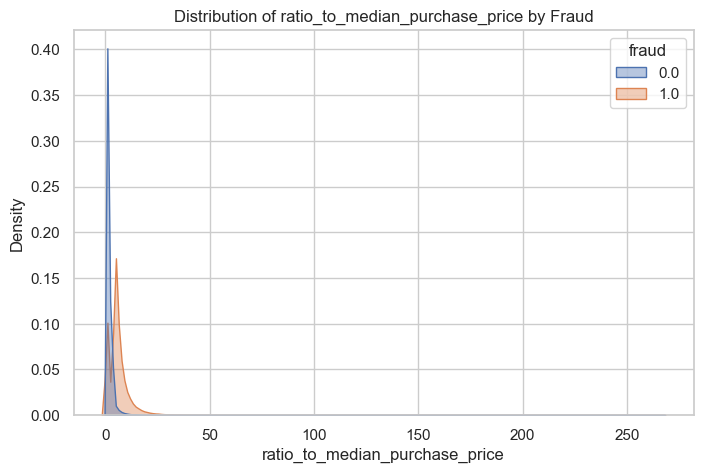

In [6]:
features_to_plot = [
    "distance_from_home",
    "distance_from_last_transaction",
    "ratio_to_median_purchase_price"
]

for col in features_to_plot:
    plt.figure()
    sns.kdeplot(
        data=df,
        x=col,
        hue="fraud",
        common_norm=False,
        fill=True,
        alpha=0.4
    )
    plt.title(f"Distribution of {col} by Fraud")
    plt.show()


## Train-Test Split (with Stratification)


In [7]:
# Features and target
X = df.drop(columns=["fraud"])
y = df["fraud"].astype(int)

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

print("\nTrain class distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest class distribution:")
print(y_test.value_counts(normalize=True))


Train shape: (800000, 7)
Test shape: (200000, 7)

Train class distribution:
fraud
0    0.912597
1    0.087402
Name: proportion, dtype: float64

Test class distribution:
fraud
0    0.912595
1    0.087405
Name: proportion, dtype: float64


## Baseline Model (Most Frequent Class)
This helps us understand how hard the problem is before using real models.

In [8]:
baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train, y_train)

y_pred_base = baseline.predict(X_test)
y_proba_base = np.zeros_like(y_test, dtype=float)  # no positive predictions

print("=== Baseline (Most Frequent Class) ===")
print(classification_report(y_test, y_pred_base, digits=4))


=== Baseline (Most Frequent Class) ===
              precision    recall  f1-score   support

           0     0.9126    1.0000    0.9543    182519
           1     0.0000    0.0000    0.0000     17481

    accuracy                         0.9126    200000
   macro avg     0.4563    0.5000    0.4772    200000
weighted avg     0.8328    0.9126    0.8709    200000



Any meaningful model must outperform this baseline, especially in **recall for the fraud class** and **PR-AUC**.


## Model Comparison with Cross-Validation (No Leakage)
We will then compare the baseline model with sveral models:
Logistic Regression (with scaling, class_weight="balanced")

Random Forest (with class_weight="balanced")

Gradient Boosting (no scaling needed)

All models are evaluated with Stratified 5-fold CV on the training set only.

In [9]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(
        class_weight="balanced",
        max_iter=1000,
        n_jobs=-1
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        random_state=42
    )
}

# Numeric features to scale (all predictors here are numeric)
numeric_features = X.columns.tolist()

# We will use a simple pipeline:
# - StandardScaler for models that benefit from scaling (LogReg)
# - Identity step (no scaling) for tree-based models

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

for name, model in models.items():
    if "Logistic" in name:
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", model)
        ])
    else:
        pipe = Pipeline([
            ("model", model)
        ])
    
    scoring = {
        "roc_auc": "roc_auc",
        "pr_auc": "average_precision"
    }
    
    cv_scores = cross_validate(
        pipe,
        X_train, y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )
    
    results.append({
        "model": name,
        "roc_auc_mean": cv_scores["test_roc_auc"].mean(),
        "roc_auc_std": cv_scores["test_roc_auc"].std(),
        "pr_auc_mean": cv_scores["test_pr_auc"].mean(),
        "pr_auc_std": cv_scores["test_pr_auc"].std()
    })

results_df = pd.DataFrame(results).sort_values("roc_auc_mean", ascending=False)
results_df


,model,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std
1,Random Forest,1.000000,1.627221e-09,1.000000,1.698324e-08
2,Gradient Boosting,0.999980,2.220388e-05,0.999923,4.546390e-05
0,Logistic Regression,0.979359,3.159085e-04,0.754968,3.682572e-03


At this point, we observe extremely high performance for tree-based models:

- Random Forest and Gradient Boosting achieve **near-perfect ROC-AUC and PR-AUC**.
- Logistic Regression achieves strong but more realistic metrics.

This discrepancy is a strong signal that **one or more features may be leaking information about the label**.



## Data Leakage Investigation


In [10]:
# Feature importance of Random  Forest
rf_raw = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf_raw.fit(X_train, y_train)

importances = pd.Series(rf_raw.feature_importances_, index=X.columns).sort_values(ascending=False)
importances


ratio_to_median_purchase_price    0.544583
distance_from_home                0.200479
online_order                      0.105746
distance_from_last_transaction    0.081818
used_pin_number                   0.033184
used_chip                         0.026334
repeat_retailer                   0.007856
dtype: float64

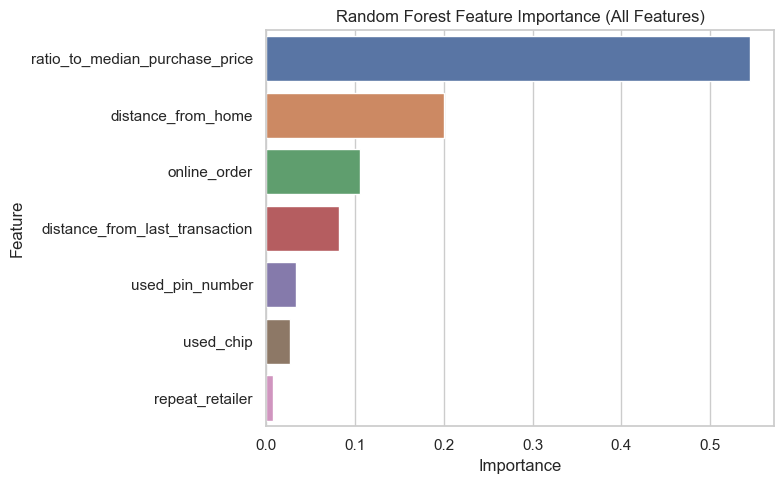

In [11]:
#PLotting Feature Importances
plt.figure(figsize =(8,5))
sns.barplot(x= importances.values, y= importances.index)
plt.title("Random Forest Feature Importance (All Features)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
           

We see that:

- `ratio_to_median_purchase_price` dominates the model with more than half of the total importance.
- A single feature contributing such a large share of importance, combined with **near-perfect AUC**, is a classic sign of a **leaky or artificially engineered feature**.

This suggests that `ratio_to_median_purchase_price` encodes information that almost directly indicates whether a transaction is fraudulent — which is unrealistic in real-world fraud detection tasks.


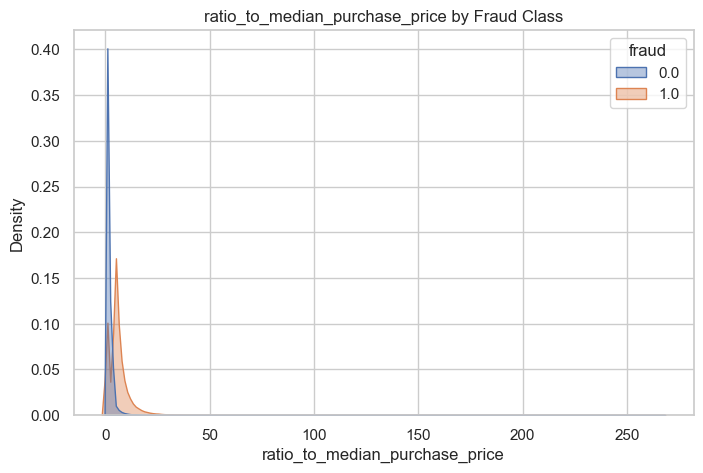

''

In [12]:
# Inspecting ratio_to_median_price by Fraud Class
plt.figure()
sns.kdeplot(
    data=df,
    x="ratio_to_median_purchase_price",
    hue="fraud",
    common_norm=False,
    fill=True,
    alpha=0.4
)
plt.title("ratio_to_median_purchase_price by Fraud Class")
plt.show()
""

This plot compares the distribution of `ratio_to_median_purchase_price` for legitimate (`0`) and fraudulent (`1`) transactions.

**Key takeaway:**  
The two distributions are almost completely separated. Legitimate transactions cluster near very small values, while fraudulent ones are shifted far to the right with minimal overlap.

**Why this matters:**  
Such a clean separation is unrealistic in real fraud detection and strongly suggests **data leakage** or a **synthetic rule-based feature**. Because this variable almost directly encodes the fraud label, models achieve artificially high performance when it is included.

**Conclusion:**  
`ratio_to_median_purchase_price` must be removed (or explicitly flagged) to ensure a realistic, non-leaky fraud detection model.


## Rebuilding Models without the leaky feature


In [13]:
#Dropping leaky feature
leaky_feature = "ratio_to_median_purchase_price"

X_clean = df.drop(columns=["fraud", leaky_feature])
y_clean = df["fraud"].astype(int)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_clean, y_clean,
    test_size=0.2,
    stratify=y_clean,
    random_state=42
)

print("Train (clean) shape:", X_train_c.shape)
print("Test (clean) shape:", X_test_c.shape)


Train (clean) shape: (800000, 6)
Test (clean) shape: (200000, 6)


In [14]:
models_clean = {
    "Logistic Regression": LogisticRegression(
        class_weight="balanced",
        max_iter=1000,
        n_jobs=-1
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        random_state=42
    )
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

for name, model in models_clean.items():
    if "Logistic" in name:
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", model)
        ])
    else:
        pipe = Pipeline([
            ("model", model)
        ])
    
    scoring = {
        "roc_auc": "roc_auc",
        "pr_auc": "average_precision"
    }
    
    cv_scores = cross_validate(
        pipe,
        X_train_c, y_train_c,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )
    
    results.append({
        "model": name,
        "roc_auc_mean": cv_scores["test_roc_auc"].mean(),
        "roc_auc_std": cv_scores["test_roc_auc"].std(),
        "pr_auc_mean": cv_scores["test_pr_auc"].mean(),
        "pr_auc_std": cv_scores["test_pr_auc"].std()
    })

results_clean = pd.DataFrame(results).sort_values("roc_auc_mean", ascending=False)
print(results_clean)


                 model  roc_auc_mean  roc_auc_std  pr_auc_mean  pr_auc_std
1        Random Forest      0.787002     0.001459     0.446852    0.003188
2    Gradient Boosting      0.786254     0.001005     0.429389    0.004123
0  Logistic Regression      0.783793     0.001726     0.344270    0.002439


After dropping `ratio_to_median_purchase_price`, model performance dropped to more realistic levels:

| Model                | ROC-AUC | PR-AUC |
|----------------------|---------|--------|
| Random Forest        | 0.787   | 0.447  |
| Gradient Boosting    | 0.786   | 0.429  |
| Logistic Regression  | 0.784   | 0.344  |

**What this means:**

- All models now achieve **ROC-AUC ~0.78**, which is typical for fraud detection tasks where the signal is subtle and no single feature dominates.
- **PR-AUC values are much lower** than before (0.34–0.45), which is expected given the class imbalance and the removal of a feature that previously encoded fraud almost directly.
- The three models perform similarly, with **Random Forest** providing the best balance of ROC-AUC and PR-AUC.

**Conclusion:**  
These results confirm that the earlier near-perfect scores were caused by data leakage. After removing the problematic feature, the model now reflects the true difficulty of the fraud detection task and provides a more trustworthy benchmark for model comparison.

In [15]:
best_model_name = results_clean.iloc[0]["model"]
print("Best model (clean features):", best_model_name)

best_base_model = models_clean[best_model_name]

if "Logistic" in best_model_name:
    best_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", best_base_model)
    ])
else:
    best_pipeline = Pipeline([
        ("model", best_base_model)
    ])

best_pipeline.fit(X_train_c, y_train_c)


Best model (clean features): Random Forest


Pipeline(steps=[('model',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_leaf=2, min_samples_split=5,
                                        n_estimators=200, n_jobs=-1,
                                        random_state=42))])

=== Test Set Performance (Clean, Random Forest) ===
              precision    recall  f1-score   support

           0     0.9363    0.9894    0.9621    182519
           1     0.7290    0.2966    0.4217     17481

    accuracy                         0.9289    200000
   macro avg     0.8327    0.6430    0.6919    200000
weighted avg     0.9181    0.9289    0.9149    200000



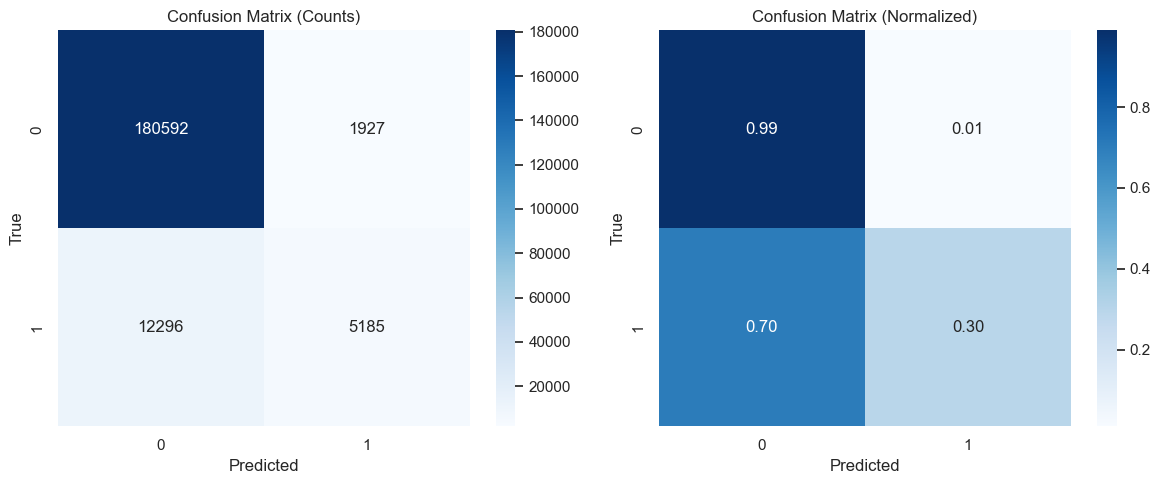

In [16]:
y_pred_c = best_pipeline.predict(X_test_c)
y_proba_c = best_pipeline.predict_proba(X_test_c)[:, 1]

print(f"=== Test Set Performance (Clean, {best_model_name}) ===")
print(classification_report(y_test_c, y_pred_c, digits=4))

cm = confusion_matrix(y_test_c, y_pred_c)
cm_norm = confusion_matrix(y_test_c, y_pred_c, normalize="true")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[0])
ax[0].set_title("Confusion Matrix (Counts)")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("True")

sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", ax=ax[1])
ax[1].set_title("Confusion Matrix (Normalized)")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("True")

plt.tight_layout()
plt.show()


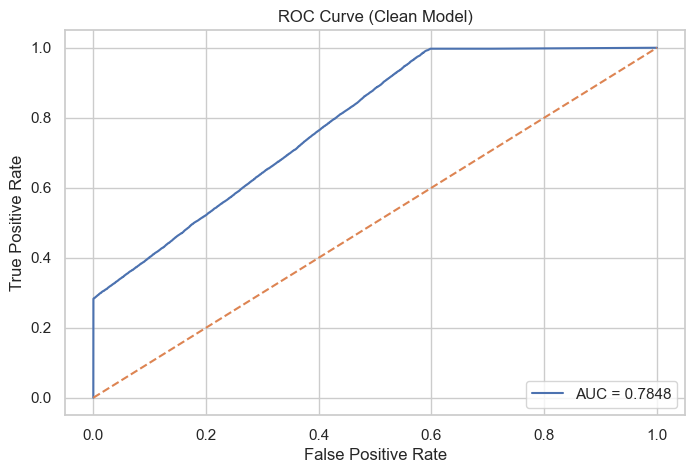

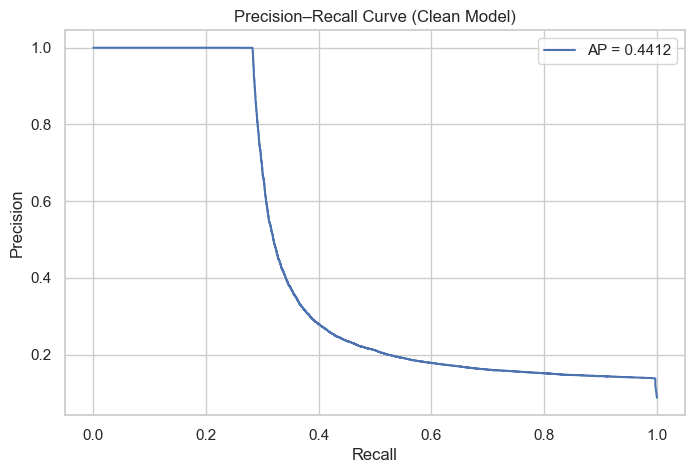

In [17]:
# ROC
fpr, tpr, _ = roc_curve(y_test_c, y_proba_c)
roc_auc = roc_auc_score(y_test_c, y_proba_c)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Clean Model)")
plt.legend(loc="lower right")
plt.show()

# PR
precision, recall, _ = precision_recall_curve(y_test_c, y_proba_c)
ap = average_precision_score(y_test_c, y_proba_c)

plt.figure()
plt.plot(recall, precision, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Clean Model)")
plt.legend(loc="upper right")
plt.show()


### Model Evaluation on Clean Test Set (After Removing Leaky Feature)

After removing the leaking feature, the Random Forest model produces realistic performance that reflects the true difficulty of the fraud detection problem.

---

## **ROC Curve (AUC = 0.7848)**  
The ROC curve shows moderate separability between fraud and non-fraud cases.  
An AUC of **0.78** indicates the model performs meaningfully better than random guessing, but the classes are not perfectly separable—expected in real fraud detection where signals are subtle.

---

## **Precision–Recall Curve (AP = 0.4412)**  
PR-AUC is more informative for imbalanced datasets.  
An **Average Precision of ~0.44** indicates the model can achieve high precision when recall is low, but maintaining high recall leads to rapidly worsening precision.  
This behavior is typical in fraud detection: the model can confidently identify a subset of fraud cases but struggles to catch all of them.

---

## **Confusion Matrix**
- The model correctly identifies **98.9% of legitimate transactions**.
- It recovers **29.7% of fraud cases** (recall for class 1).
- When it predicts fraud, it's correct **72.9% of the time** (precision for class 1).

This trade-off is common:  
The model is conservative about flagging fraud (to avoid many false positives), which results in **higher precision but lower recall** for fraudulent transactions.

---

## **Summary**
- Removing the leaky feature results in a far more realistic performance profile.
- ROC-AUC ≈ **0.78** and PR-AUC ≈ **0.44** indicate that the model finds meaningful fraud signals without relying on artificially predictive features.
- The model is good at identifying a **high-confidence subset** of fraud cases, but may miss others—highlighting the need for further techniques such as:
  - Threshold tuning  
  - Cost-sensitive learning  
  - SMOTE or other resampling methods  
  - Ensemble or anomaly-detection approaches  

Overall, these results represent a trustworthy baseline for  fraud detection modeling.
